In [1]:
%load_ext autoreload
%autoreload 2
from distributions import MixtureModel, ZeroInflatedDist, QuantizedDist, QuantizedNormal
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats 
from plotting_funcs import plot_dist, sample_and_plot

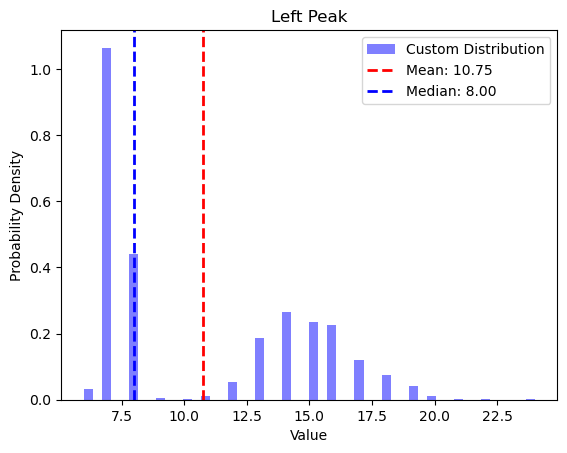

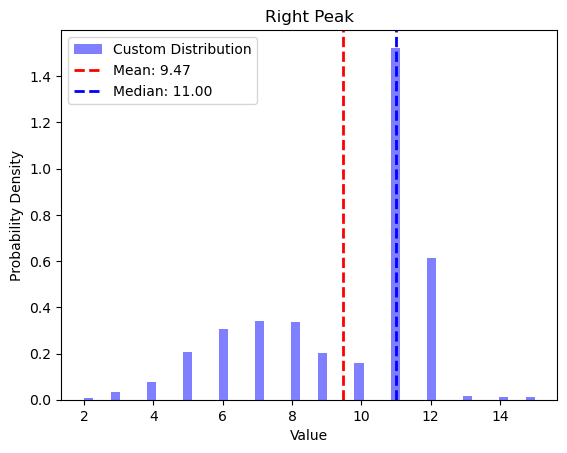

In [2]:
# Define parameters for the custom distribution
weights_left = [.55, .45]        # weights of each component
means_left = [7.0, 13.0]         # means of each component
scales_left = [.5, 3.0]         # scales of each component
shapes_left = [1, 2]         # shapes of each component

weights_right = weights_left
means_right = [11, 5]
scales_right = [0.5, 3]
shapes_right = [1, 2]

# Create a list of normal distributions
skewed_left_peak_dists = [scipy.stats.skewnorm(a, loc=loc, scale=scale) 
                          for a, loc, scale in zip(shapes_left, means_left, scales_left)]

skewed_right_peak_dists = [scipy.stats.skewnorm(a, loc=loc, scale=scale) 
                          for a, loc, scale in zip(shapes_right, means_right, scales_right)]

# Create a random variable representing the custom distribution
left_peak_5 = [QuantizedDist(MixtureModel(skewed_left_peak_dists, weights=weights_left)) for _ in range(5)]
right_peak_5 = [QuantizedDist(MixtureModel(skewed_right_peak_dists, weights=weights_right)) for _ in range(5)]

plot_dist(left_peak_5[0], 'Left Peak')
plot_dist(right_peak_5[0], 'Right Peak')

In [3]:
consistent_5 = [QuantizedNormal(10, 0.1) for _ in range(5)]

highvar_5 = [ZeroInflatedDist(QuantizedNormal(15, 0.1), 0.3333) for _ in range(5)]

powerball_5 = [ZeroInflatedDist(QuantizedNormal(100, 0.1), 0.9) for _ in range(5)]

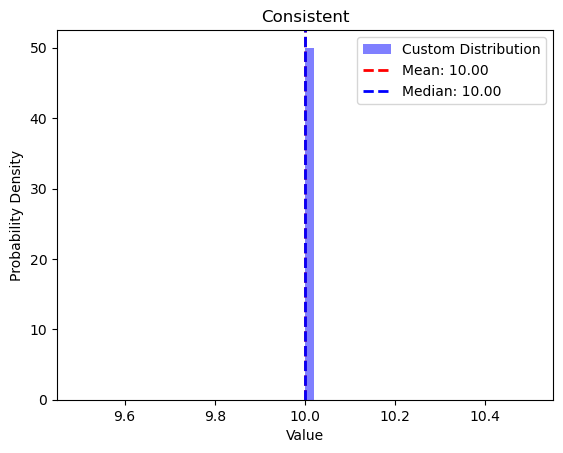

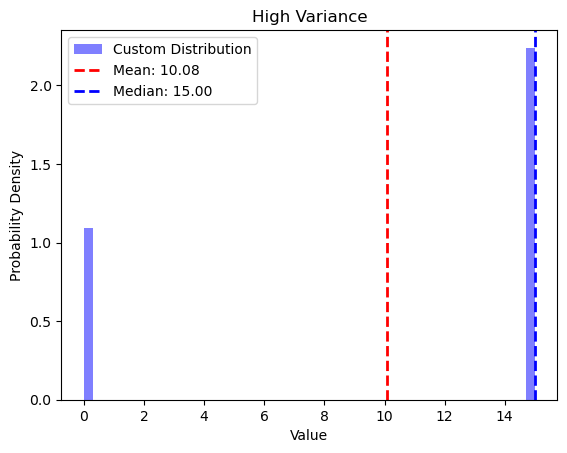

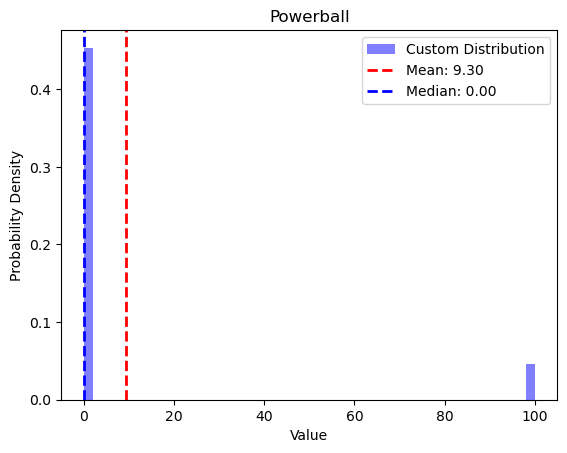

In [4]:
plot_dist(consistent_5[0], 'Consistent')
plot_dist(highvar_5[0], 'High Variance')
plot_dist(powerball_5[0], 'Powerball')

In [5]:
dist_N = highvar_5 + right_peak_5 +consistent_5 + left_peak_5 +  powerball_5 

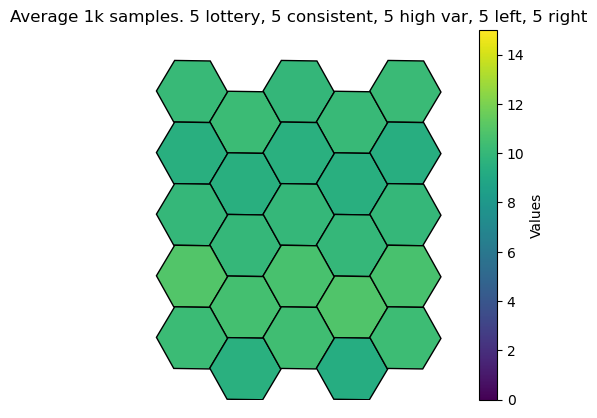

In [6]:
sample_and_plot(dist_N, size=1000, average=True, title='Average 1k samples. 5 lottery, 5 consistent, 5 high var, 5 left, 5 right', vmin=0, vmax=15)

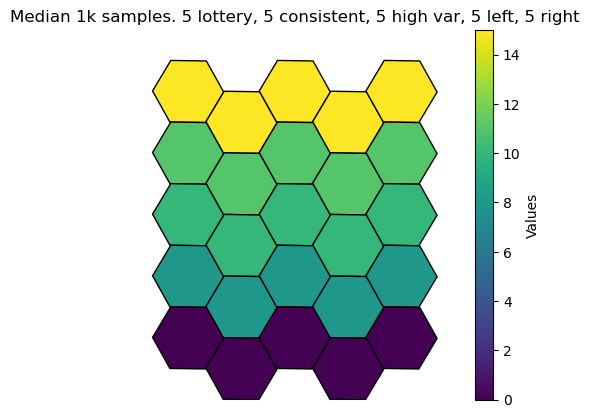

In [7]:
sample_and_plot(dist_N, size=1000, median=True, title='Median 1k samples. 5 lottery, 5 consistent, 5 high var, 5 left, 5 right', vmin=0, vmax=15)

In [8]:
def calc_bpr_many_trials(
        dist_N, K=3, n_trials=10000,s_samples=10000,
        seed=101,
        strategy='pick_mean',
        percentile_as_frac=0.95):
    N = len(dist_N)
    y_RN = np.zeros((n_trials, N), dtype=np.int32)
    for n, dist in enumerate(dist_N):
        random_state = np.random.RandomState(10000 * seed + n)
        y_RN[:, n] = dist.rvs(size=n_trials, random_state=random_state)

    if strategy == 'cross_ratio':
        S = s_samples*n_trials
        y_SN = np.zeros((S, N))
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_SN[:,n] = dist.rvs(size=S, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_SN[:,n], p)
                                    for p in [0, 10, 50, 90, 100]])
        ratio_N = np.mean(y_SN / np.sum(y_SN, axis=1, keepdims=1), axis=0)
        assert ratio_N.shape == (N,)
        selected_ids_K = np.argsort(-1 * ratio_N)[:K]

        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    if strategy == 'cross_ratio_topk':
        S = s_samples*n_trials
        y_SN = np.zeros((S, N))
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_SN[:,n] = dist.rvs(size=S, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_SN[:,n], p)
                                    for p in [0, 10, 50, 90, 100]])

        topk_ids_SN = np.argsort(-1 * y_SN, axis=1)[:, :K]
        topk_y_SN = np.take_along_axis(y_SN, topk_ids_SN, axis=1)
        ratiotopk_N = np.mean(y_SN / np.sum(topk_y_SN, axis=1, keepdims=1), axis=0)
        assert ratiotopk_N.shape == (N,)
        selected_ids_K = np.argsort(-1 * ratiotopk_N)[:K]

        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    if strategy == 'guess_random':
        random_state = np.random.RandomState(10000 * seed)
        selected_ids_RK = np.zeros((n_trials, K), dtype=np.int32)
        for trial in range(n_trials):
            selected_ids_RK[trial,:] = random_state.permutation(N)[:K]

    if strategy.count('pick'):
        score_N = np.zeros(N)
        sum_str_N = [None for _ in range(N)]
        for n, dist in enumerate(dist_N):
            random_state = np.random.RandomState(10000 * seed + n)
            y_samples_S = dist.rvs(size=s_samples*n_trials, random_state=random_state)
            sum_str_N[n] = " ".join(['%.1f' % np.percentile(y_samples_S, p)
                                    for p in [0, 10, 50, 90, 100]])
            
            if strategy == 'pick_mean':
                score_N[n] = np.mean(y_samples_S)
            if strategy == 'pick_consistent':
                score_N[n] = 1 if n < 5 else 0
            if strategy == 'pick_variance':
                score_N[n] = 1 if n >=5 and n < 10 else 0
            if strategy == 'pick_lottery':
                score_N[n] = 1 if n >=10 and n <15 else 0
            if strategy == 'pick_left':
                score_N[n] = 1 if n >=15 and n <20 else 0
            if strategy == 'pick_right':
                score_N[n] = 1 if n >=20 else 0
            if strategy == 'pick_each':
                score_N[n] = 1 if n == 0 or n==4 or n==7 else 0
            if strategy == 'pick_median':
                score_N[n] = np.median(y_samples_S)
            elif strategy == 'pick_percentile':
                score_N[n] = np.percentile(y_samples_S, percentile_as_frac)  

        selected_ids_K = np.argsort(-1 * score_N)[:K]

        selected_ids_RK = np.tile(selected_ids_K, (n_trials,1))

    yselect_RK = np.take_along_axis(y_RN, selected_ids_RK, axis=1)
    topk_ids_RK = np.argsort(-1 * y_RN, axis=1)[:, :K]
    ytop_RK = np.take_along_axis(y_RN, topk_ids_RK, axis=1)

    numer_R = np.sum(yselect_RK, axis=1)
    denom_R = np.sum(ytop_RK, axis=1)
    
    assert np.all(numer_R <= denom_R + 1e-10)
    
    return numer_R / denom_R


In [9]:
mnames = ['cross_ratio','cross_ratio_topk', 'pick_median', 'pick_mean','guess_random']
R = 1000
S = 1000 
winners = []
for K in range(1,25+1):
    print(K)
    scores_MR = np.zeros((len(mnames), R))
    for mm, method in enumerate(mnames):
        scores_MR[mm] = calc_bpr_many_trials(
            dist_N, K=K, n_trials=R,s_samples=S, strategy=method)
        
    winscore_1R = scores_MR.max(axis=0, keepdims=1)

    winners_MR = np.abs(scores_MR - winscore_1R) < 1e-6

    ranks = scipy.stats.rankdata(np.sum(winners_MR,axis=1),method='max')
    winners.append(ranks)

1
2


KeyboardInterrupt: 

In [49]:
winners_reversed = scipy.stats.rankdata(-np.array(winners),axis=1,method='max')
# Transpose the array to have 4 rows and M columns
transposed_array = winners_reversed.T

# Print the transposed array
for row in transposed_array:
    print("\t".join(map(str, row)))

4	2	4	3	2	3	2	2	2	3	3	2	2	2	2	2	1	1	3	3	2	2	2	3	5
2	3	2	4	4	2	3	3	3	2	2	1	1	1	1	1	2	2	2	3	2	2	2	3	5
1	1	1	1	1	1	1	1	1	1	1	3	3	4	4	4	4	4	4	3	3	3	3	1	5
3	4	3	2	3	5	5	5	4	4	5	5	5	5	5	5	5	3	1	4	4	5	5	5	5
5	5	5	5	5	4	4	4	5	5	4	4	4	3	3	3	3	5	5	5	5	4	4	4	5


In [11]:
mnames = ['cross_ratio','cross_ratio_topk', 'pick_median', 'pick_mean','guess_random']
K = 5
R = 1000
S = 1000 
scores_MR = np.zeros((len(mnames), R))
for mm, method in enumerate(mnames):
    scores_MR[mm] = calc_bpr_many_trials(
        dist_N, K=K, n_trials=R, s_samples=S, strategy=method)
    
winscore_1R = scores_MR.max(axis=0, keepdims=1)

winners_MR = np.abs(scores_MR - winscore_1R) < 0.02

print(f'K={K}')
for mm, mname in enumerate(mnames):
    print("%25s E[BPR] %0.2f won % 6d/%d trials" % (mname, scores_MR[mm].mean(), winners_MR[mm].sum(), R))

K=5
              cross_ratio E[BPR] 0.56 won    546/1000 trials
         cross_ratio_topk E[BPR] 0.56 won    546/1000 trials
              pick_median E[BPR] 0.51 won    408/1000 trials
                pick_mean E[BPR] 0.56 won    546/1000 trials
             guess_random E[BPR] 0.46 won    181/1000 trials


In [13]:
mnames = ['cross_ratio','cross_ratio_topk','pick_median', 'pick_mean','guess_random','pick_consistent','pick_left','pick_right','pick_variance','pick_lottery']
R = 1000
S = 1000
for K in [3,5,10]:
    scores_MR = np.zeros((len(mnames), R))
    for mm, method in enumerate(mnames):
        scores_MR[mm] = calc_bpr_many_trials(
            dist_N, K=K, n_trials=R, s_samples=S, strategy=method)
        
    winscore_1R = scores_MR.max(axis=0, keepdims=1)

    winners_MR = np.abs(scores_MR - winscore_1R) < 0.02

    print(f'K={K}')
    for mm, mname in enumerate(mnames):
        print("%25s won % 6d/%d trials" % (mname, winners_MR[mm].sum(), R))


K=3
              cross_ratio won    144/1000 trials
         cross_ratio_topk won    134/1000 trials
              pick_median won    175/1000 trials
                pick_mean won    139/1000 trials
             guess_random won    122/1000 trials
          pick_consistent won    179/1000 trials
                pick_left won    179/1000 trials
               pick_right won    247/1000 trials
            pick_variance won     69/1000 trials
             pick_lottery won     84/1000 trials
K=5
              cross_ratio won    164/1000 trials
         cross_ratio_topk won    163/1000 trials
              pick_median won    157/1000 trials
                pick_mean won    159/1000 trials
             guess_random won     95/1000 trials
          pick_consistent won    165/1000 trials
                pick_left won    172/1000 trials
               pick_right won    348/1000 trials
            pick_variance won     44/1000 trials
             pick_lottery won     62/1000 trials
K=10
       

In [52]:
scores_MR

array([[0.48471616, 0.456621  , 0.51121076, ..., 0.7480916 , 0.46320346,
        0.31089744],
       [0.47767857, 0.47321429, 0.51754386, ..., 0.71969697, 0.45132743,
        0.30967742],
       [0.44736842, 0.44545455, 0.4122807 , ..., 0.83458647, 0.52212389,
        0.3442623 ],
       ...,
       [0.47787611, 0.51598174, 0.41964286, ..., 0.8671875 , 0.43043478,
        0.28802589],
       [0.49773756, 0.43981481, 0.42792793, ..., 0.83969466, 0.55555556,
        0.36184211],
       [0.71111111, 0.59633028, 0.63596491, ..., 0.34351145, 0.71111111,
        0.85245902]])

In [22]:
def debug(
        dist_N, K=3, n_trials=10000,s_samples=10000,
        seed=101,):
    N = len(dist_N)
    y_RN = np.zeros((n_trials, N), dtype=np.int32)
    for n, dist in enumerate(dist_N):
        random_state = np.random.RandomState(10000 * seed + n)
        y_RN[:, n] = dist.rvs(size=n_trials, random_state=random_state)

    S = s_samples*n_trials
    y_SN = np.zeros((S, N))
    for n, dist in enumerate(dist_N):
        random_state = np.random.RandomState(10000 * seed + n)
        y_SN[:,n] = dist.rvs(size=S, random_state=random_state)
    # cross ratio block
        
            
    ratio_N = np.mean(y_SN / np.sum(y_SN, axis=1, keepdims=1), axis=0)
    assert ratio_N.shape == (N,)
    selected_ids_K_ratio = np.argsort(-1 * ratio_N)[:K]

    selected_ids_RK_ratio = np.tile(selected_ids_K_ratio, (n_trials,1))

    #cross ratio topk block
    topk_ids_SN = np.argsort(-1 * y_SN, axis=1)[:, :K]
    topk_y_SN = np.take_along_axis(y_SN, topk_ids_SN, axis=1)
    ratiotopk_N = np.mean(y_SN / np.sum(topk_y_SN, axis=1, keepdims=1), axis=0)
    assert ratiotopk_N.shape == (N,)
    selected_ids_K_topk = np.argsort(-1 * ratiotopk_N)[:K]

    selected_ids_RK_topk = np.tile(selected_ids_K_topk, (n_trials,1))

    
    yselect_RK_ratio = np.take_along_axis(y_RN, selected_ids_RK_ratio, axis=1)
    yselect_RK_topk = np.take_along_axis(y_RN, selected_ids_RK_topk, axis=1)
    topk_ids_RK = np.argsort(-1 * y_RN, axis=1)[:, :K]
    ytop_RK = np.take_along_axis(y_RN, topk_ids_RK, axis=1)

    numer_R_ratio = np.sum(yselect_RK_ratio, axis=1)
    numer_R_topk = np.sum(yselect_RK_topk, axis=1)
    denom_R = np.sum(ytop_RK, axis=1)
    
    #assert np.all(numer_R <= denom_R + 1e-10)
    
    return #numer_R / denom_R
    


In [24]:
 debug(dist_N, K=5, n_trials=1000, s_samples=1000)

In [33]:
random_state = np.random.RandomState(1)
dist_N[0].rvs(size=1000, random_state=random_state)

for n, dist in enumerate(dist_N):
    random_state = np.random.RandomState(1)
    first_samples = dist_N[n].rvs(size=10000, random_state=random_state)
    for _ in range(100):
        random_state = np.random.RandomState(1)
        new_samples = dist_N[n].rvs(size=10000, random_state=random_state)
        try:
            assert np.array_equal(first_samples, new_samples)
        except AssertionError:
            print(namesn)
            break


5
6
7
8
9
15
16
17
18
19
